# Data Science Assessment - Predicting Domino’s Pizza KPIs using Edison’s email receipt data


# AIM

##### 1. Using the order receipts sent via email predict KPIs for Domino’s pizza Q1 2016 – on.
##### 2. Compare the results with the actual revenue QoQ and YoY changes.
##### 3. Estimate the Q3 2018 domestic franchise revenue.

In [1]:
#importing all the necessary packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pyspark import sql, SparkConf, SparkContext
from pyspark.sql import functions as func
from pyspark.sql.functions import unix_timestamp, col, to_date, from_unixtime, to_timestamp, lit, min, max, count, avg,isnan, when, count, coalesce, month, year
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import timestring as ts
import datetime
from dateutil.relativedelta import relativedelta
pd.options.display.max_columns = None
from sklearn.linear_model import LinearRegression

In [2]:
os.environ["PYSPARK_PYTHON"]="python3.6"
os.environ["PYSPARK_DRIVER_PYTHON"]="python3.6"

In [3]:
#starting the spark session

conf = SparkConf().setAppName("Edison_Dominos").set("spark.executor.cores", "8")
sc = SparkContext(conf=conf)
sqlContext = sql.SQLContext(sc)

In [4]:
#Actual Quarterly Revenue

actual_revenue = pd.read_excel("./dominos_revenue.xlsx", index_col = 0)

In [5]:
#loading the data in a spark dataframe

df = sqlContext.read.csv("./edison_dominos_receipts.csv", header=True)

# Data Preparation


#### 1. _order__time_ has 108 missing values. But we do have all the data for _email__time_. This can be used as a proxy for _order__time_ since in most cases the email is sent out immediately after the order is placed. However, sometimes there's a delay. This is either due to ordering in different time zone or some delay from domino's side. _email__time_ is as close as we can get.

#### 2. Some of the _order__total__amount_ is zero or close to zero. This could be due to some promotion or some error during data collection. Domino's has something called as piece of pie rewards program in which you get a pizza order after every 6th order. Domino's also offer free pizza in cases of late delivery, wrong order, etc. For sake of simplicity, I decided to leave the _order__total__amount_ untouched. 

#### 3. _from__domain_ is an important column. This will be used to distinguish domestic orders from international orders. This column has around 670 missing values. But based on other columns for rows where _from__domain_ is null, it seems that these are domestic orders. 

#### 4. Some other data checks and cleaning were performed which I will talk about as we go through the code.

In [6]:
#checking for columns with Null values

#before filling null values in order_time

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
user_id,0
merchant_name,0
order_number,0
order_time,108
email_time,0
update_time,0
insert_time,0
order_total_amount,0
order_points,10944046
order_shipping,2372939


##### Important point to note -- order_time has 108 null values. No worries -- we have email_time and that can be a good proxy for order_time.

In [7]:
df = df.withColumn("order_time",coalesce(df.order_time,df.email_time))

In [8]:
#after filling missing_values in order_time

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
user_id,0
merchant_name,0
order_number,0
order_time,0
email_time,0
update_time,0
insert_time,0
order_total_amount,0
order_points,10944046
order_shipping,2372939


In [9]:
#looking at 5 rows to see how the data looks.
df.limit(2).toPandas().head().T

,0,1
user_id,00020901e9c55493da2677dbb4141e208d226801b97a33...,00020901e9c55493da2677dbb4141e208d226801b97a33...
merchant_name,Domino's Pizza,Domino's Pizza
order_number,36567,36567
order_time,2016-12-06 19:49:00,2016-12-06 19:49:00
email_time,2016-12-07 00:49:26,2016-12-07 00:49:26
update_time,2018-07-04 12:00:40,2018-07-04 12:00:40
insert_time,2016-12-08 01:44:20,2016-12-08 01:44:20
order_total_amount,12.98,12.98
order_points,None,None
order_shipping,None,None


In [10]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- order_number: string (nullable = true)
 |-- order_time: string (nullable = true)
 |-- email_time: string (nullable = true)
 |-- update_time: string (nullable = true)
 |-- insert_time: string (nullable = true)
 |-- order_total_amount: string (nullable = true)
 |-- order_points: string (nullable = true)
 |-- order_shipping: string (nullable = true)
 |-- order_tax: string (nullable = true)
 |-- item_total: string (nullable = true)
 |-- order_total_qty: string (nullable = true)
 |-- product_description: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- item_price: string (nullable = true)
 |-- digital_transaction: string (nullable = true)
 |-- checksum: string (nullable = true)
 |-- product_reseller: string (nullable = true)
 |-- order_discount: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- order_pickup: string (nullable

In [11]:
#ensuring that we have receipt data ONLY for dominos

df.select('merchant_name').distinct().show()

+--------------+
| merchant_name|
+--------------+
|Domino's Pizza|
+--------------+



In [12]:
#dropping all the columns that will not be used.

#update_time -- almost the same time period
#order_points -- null throughout
#merchant_name -- domino's pizza
#product_reseller -- null throughout
#item_id -- null throughout
#SKU -- null throughout
#email_subject -- will not be used.

drop_list = ["update_time", "order_points", "merchant_name", "product_reseller", "item_id", "SKU", "email_subject",
            "check_sum"]
df = df.select([column for column in df.columns if column not in drop_list])

In [13]:
#getting columns that are time and date
time_columns = [col for col in df.columns if "time" in col]
for column in time_columns:
    df = df.withColumn(column, to_timestamp(unix_timestamp(col(column), 'yyyy-MM-dd HH:mm:ss')))

#columns to be converted to float
float_columns = ["order_total_amount", "order_shipping", "order_tax", "item_total", "item_price"]
for col_name in float_columns:
    df = df.withColumn(col_name, col(col_name).cast('float'))

#columns to be converted to int
int_columns = ["order_total_qty", "quantity"]
for col_name in int_columns:
    df = df.withColumn(col_name, col(col_name).cast('int'))

In [14]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- order_number: string (nullable = true)
 |-- order_time: timestamp (nullable = true)
 |-- email_time: timestamp (nullable = true)
 |-- insert_time: timestamp (nullable = true)
 |-- order_total_amount: float (nullable = true)
 |-- order_shipping: float (nullable = true)
 |-- order_tax: float (nullable = true)
 |-- item_total: float (nullable = true)
 |-- order_total_qty: integer (nullable = true)
 |-- product_description: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- item_price: float (nullable = true)
 |-- digital_transaction: string (nullable = true)
 |-- checksum: string (nullable = true)
 |-- order_discount: string (nullable = true)
 |-- order_pickup: string (nullable = true)
 |-- from_domain: string (nullable = true)
 |-- user_create_time: timestamp (nullable = true)
 |-- user_last_process_day: string (nullable = true)
 |-- expiry_time: timestamp (nullable = true)
 |-- billing_zip: string (nullable = true)
 |-

In [15]:
df.limit(2).toPandas().head().T

,0,1
user_id,00020901e9c55493da2677dbb4141e208d226801b97a33...,00020901e9c55493da2677dbb4141e208d226801b97a33...
order_number,36567,36567
order_time,2016-12-06 19:49:00,2016-12-06 19:49:00
email_time,2016-12-07 00:49:26,2016-12-07 00:49:26
insert_time,2016-12-08 01:44:20,2016-12-08 01:44:20
order_total_amount,12.98,12.98
order_shipping,NaN,NaN
order_tax,0,0
item_total,12.98,12.98
order_total_qty,2,2


So looking at the domain name, it can be seen that we have international orders from several countries. It should be noted that looking at the international data will not give concrete numbers because we are missing data for Asian countries where domino's is quite dominant -- India, China, Sri Lanka, etc. However, we look at the data both the ways -- international and domestic.

# Data Transformation

#### 1. Looking at the domain name, it is clear that we also have international orders from countries like Australia, New Zealand, Guam, etc. But, these orders are not a lot in number. Since, we are focussing on domestic franchise revenue, I decided to look at two separate views -- global and domestic. I don't expect to see much of a difference due to the fact that international orders are very few in numbers. 

#### 2. Orders have been tagged by quarter and year as per order_time.

Also, it's not possible to differentiate between domestic franchise-owned and company owned stores. However, a simple google search and first link of dominos states that 97% of the dominos store are franchise-owned stores.





https://biz.dominos.com/web/public/about-dominos/fun-facts

In [16]:
#here I convert foreign currency to USD. A better way would be to get the time series data and match it 
#with the order date. I tried to get the currency data using pandas_datareader but it doesn't have data for
#few currencies.

def convert_currency(order_amt, domain):
    FX_rates = {
        "orders@dominos.kn": 0.37,
        "orders@dominos.com": 1,
        "orders@dominos.com.jm": 0.008,
        "orders@dominos.ky": 1.20,
        "no-reply@vip.dominos.com.au": 0.7,
        "orders@dominos.ca": 0.7,
        "webuser@dominos.com.sg": 0.7,
        "no-reply@vip.dominos.co.nz": 0.7,
        "orders@dominos.sx": 0.55,
        "orders@dominos.ec": 1,
        "orders@dominospr.com":1,
        "orders@dominos.gu": 1,
        "orders@dominos.pa": 1,
        None: 1
    }

    return order_amt * FX_rates[domain]

filter_udf = udf(convert_currency, FloatType())
df = df.withColumn("order_total_amount", filter_udf("order_total_amount", "from_domain"))


#getting the quarter for the order dates

def quarter_year(order_date):
    quarter = (order_date.month - 1)//3 + 1
    year = order_date.year
    return "Q"+str(quarter)+" "+str(year)

quarter_udf = udf(quarter_year, StringType())
df = df.withColumn("order_quarter", quarter_udf("order_time"))

In [17]:
df.limit(2).toPandas().T

,0,1
user_id,00020901e9c55493da2677dbb4141e208d226801b97a33...,00020901e9c55493da2677dbb4141e208d226801b97a33...
order_number,36567,36567
order_time,2016-12-06 19:49:00,2016-12-06 19:49:00
email_time,2016-12-07 00:49:26,2016-12-07 00:49:26
insert_time,2016-12-08 01:44:20,2016-12-08 01:44:20
order_total_amount,12.98,12.98
order_shipping,NaN,NaN
order_tax,0,0
item_total,12.98,12.98
order_total_qty,2,2


# Data Bias

There are two ways to calculate the KPIs in order to avoid bias. 

#### <br> 1. We ensure that we have the same user population throughout the time period i.e. 2016 - 2018
#### <br> 2. We ensure that we have the same user population for consecutive time periods. But this is good only for calculating percentage changes in revenue. We cannot compare the revenue in terms of absolute value.

Also, we have to make sure that we have orders starting 01-01-2016

For method 1, we need to ensure that all users have joined the app before 2016 and none of them stopped using it during this period. This can be done by filtering on user_create_time and expiry_time.

In [18]:
def trend(series):
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

In [19]:
quarters_ = ["Q" + str(quarter)+" "+str(year) for year in range(2016, 2019) for quarter in range(1,5)]
quarters_.pop()

'Q4 2018'

In [20]:
#filtering out domestic data based on domain names. (US, Puerto Rico, Guam and None values.)
df_domestic = df.filter((df.from_domain == "orders@dominos.com") | (df.from_domain == "orders@dominospr.com")
                                                                   | (df.from_domain == "orders@dominos.gu") |
                                                                   (df.from_domain.isNull()))

#filtering out data -- orders after 2016 and users that joined before 2016 and didn't delete the app.
data_domestic_2yrs = df_domestic.filter(df_domestic.user_create_time < to_timestamp(lit("2016-01-01 00:00:00"))).filter(
    df_domestic.expiry_time.isNull()).filter(df_domestic.order_time >= to_timestamp(lit("2016-01-01 00:00:00")))

orders_ = df_domestic.filter(df_domestic.user_create_time < to_timestamp(lit("2016-01-01 00:00:00"))).filter(df_domestic.order_time >= to_timestamp(lit("2016-01-01 00:00:00")))


orders_ = orders_.groupBy("order_number").agg(func.first("order_total_amount").alias("order_total"), func.first("order_quarter").alias("order_quarter"),
                                                                func.first("order_time").alias("order_time"), func.first("expiry_time").alias("expiry_time"),
                                                                func.first("user_create_time").alias("user_create_time"))

#grouping all individual items into one order.
orders_domestic = data_domestic_2yrs.groupBy("order_number").agg(func.first("order_total_amount").alias("order_total"), func.first("order_quarter").alias("order_quarter"),
                                                                func.first("order_time").alias("order_time"), func.first("expiry_time").alias("expiry_time"),
                                                                func.first("user_create_time").alias("user_create_time"))

#calculating the revenue.
revenue_domestic = orders_domestic.groupby("order_quarter").agg(func.sum("order_total")).toPandas()

In [21]:
orders_domestic.show(5)

+------------+-----------+-------------+-------------------+-----------+-------------------+
|order_number|order_total|order_quarter|         order_time|expiry_time|   user_create_time|
+------------+-----------+-------------+-------------------+-----------+-------------------+
|     1010896|      35.82|      Q4 2017|2017-12-09 19:54:00|       null|2014-02-06 00:55:08|
|      101205|      25.21|      Q3 2017|2017-09-30 19:28:00|       null|2013-03-07 15:39:21|
|     1015263|      20.93|      Q2 2018|2018-05-12 18:33:00|       null|2014-07-09 16:36:06|
|     1023646|      27.22|      Q4 2016|2016-11-08 16:29:00|       null|2015-01-11 16:21:30|
|      103123|      13.96|      Q4 2017|2017-10-28 16:52:00|       null|2015-08-28 18:00:58|
+------------+-----------+-------------+-------------------+-----------+-------------------+
only showing top 5 rows



In [22]:
revenue_domestic.set_index("order_quarter", inplace = True)
revenue_domestic = revenue_domestic.reindex(quarters_)
revenue_domestic

,sum(order_total)
order_quarter,
Q1 2016,300981.209715
Q2 2016,304495.679976
Q3 2016,325314.439644
Q4 2016,363156.009926
Q1 2017,347239.569675
Q2 2017,363599.229728
Q3 2017,411840.219844
Q4 2017,442885.929795
Q1 2018,446804.699608


### Calculating the number of orders per month

In [23]:
num_orders_quarter = orders_domestic.groupBy("order_quarter").agg(count("order_number").alias("num_orders")).toPandas()
num_orders_quarter.set_index("order_quarter", inplace = True)
num_orders_quarter = num_orders_quarter.reindex(quarters_)

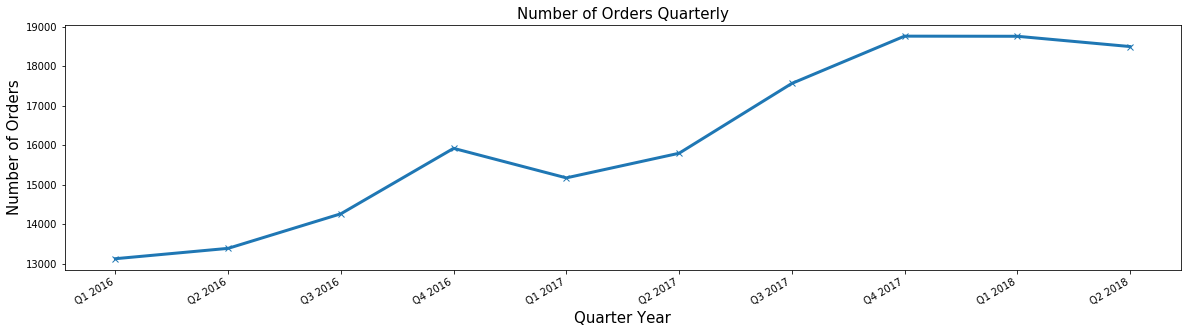

In [24]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(num_orders_quarter.index[:-1], num_orders_quarter["num_orders"][:-1], marker='x', linestyle='-', linewidth = 3);
fig.autofmt_xdate();
plt.xlabel("Quarter Year", fontsize = 15)
plt.ylabel("Number of Orders", fontsize = 15)
plt.title("Number of Orders Quarterly", fontsize = 15)
plt.show();

### Calculating the number of orders per month

In [25]:
num_orders_month = orders_domestic.groupBy(func.year("order_time").alias("year"), month("order_time").alias("month")).agg(func.count("order_number").alias("num_orders")).toPandas()
num_orders_month = num_orders_month.groupby(["year", "month"])["num_orders"].sum().to_frame()

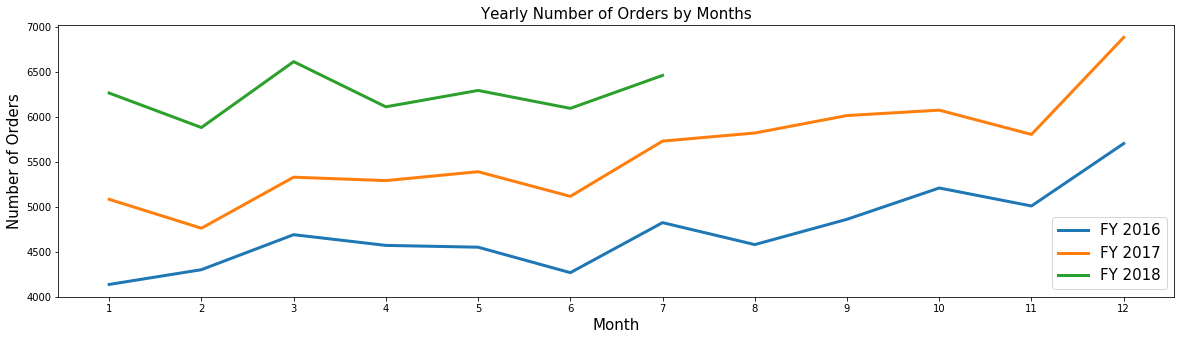

In [26]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
for yr in range(2016, 2019):
    ax.plot(num_orders_month.unstack(level=0)["num_orders"][yr], linewidth = 3, label ="FY "+str(yr));
ax.set_xticks([i for i in range(1, 13)]);
plt.xlabel("Month", fontsize = 15);
plt.ylabel("Number of Orders", fontsize = 15);
plt.title("Yearly Number of Orders by Months", fontsize = 15);
ax.legend(loc="best", fontsize = 15);

### Number of Orders Time Series

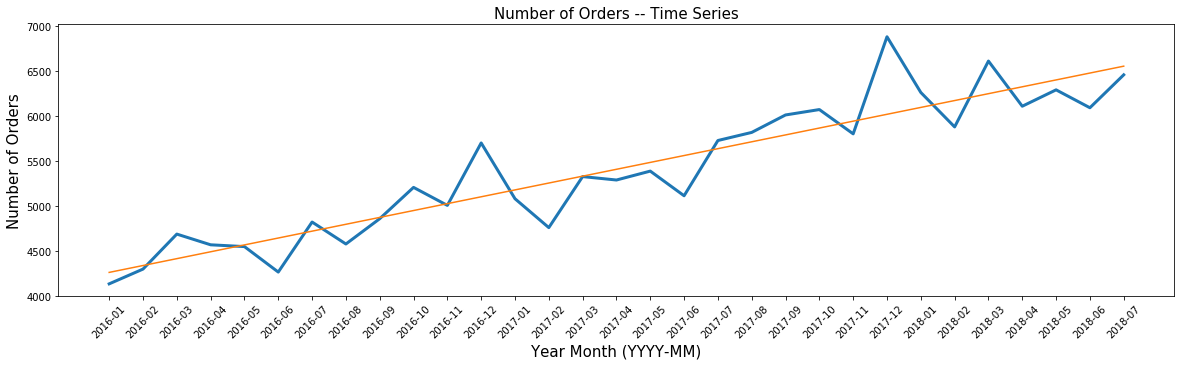

In [27]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot(num_orders_month["num_orders"].values, linewidth = 3)
ax.plot(trend(num_orders_month["num_orders"].values))
ax.set_xticks(range(len(num_orders_month)));
ax.set_xticklabels(["%s-%02d" % item for item in num_orders_month.index.tolist()], rotation=45);
plt.xlabel("Year Month (YYYY-MM)", fontsize = 15);
plt.ylabel("Number of Orders", fontsize = 15);
plt.title("Number of Orders -- Time Series", fontsize = 15);

### Average monthly $ order size

In [28]:
avg_dollar_monthly = orders_domestic.groupBy(func.year("order_time").alias("year"), month("order_time").alias("month")).agg(avg("order_total").alias("avg_order_total")).toPandas()
avg_dollar_monthly = avg_dollar_monthly.groupby(["year", "month"])["avg_order_total"].sum().to_frame()

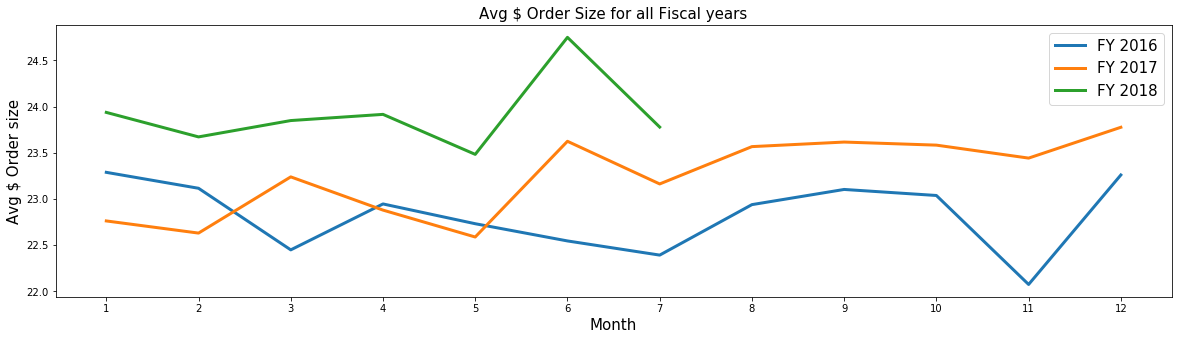

In [29]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
for yr in range(2016, 2019):
    ax.plot(avg_dollar_monthly.unstack(level=0)["avg_order_total"][yr], linewidth = 3, label ="FY "+str(yr));
plt.xlabel("Month", fontsize = 15);
plt.ylabel("Avg $ Order size", fontsize = 15);
plt.title("Avg $ Order Size for all Fiscal years", fontsize = 15);
ax.set_xticks([i for i in range(1, 13)]);
ax.legend(loc="best", fontsize = 15);

### Avg $ order size monthly time series

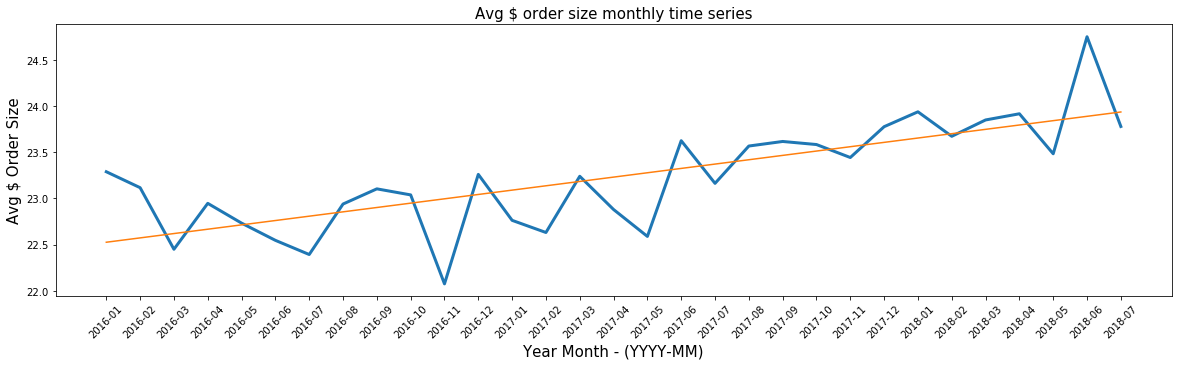

In [30]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot(avg_dollar_monthly["avg_order_total"].values, linewidth = 3)
ax.plot(trend(avg_dollar_monthly["avg_order_total"].values))
ax.set_xticks(range(len(avg_dollar_monthly)));
plt.xlabel("Year Month - (YYYY-MM)", fontsize = 15);
plt.ylabel("Avg $ Order Size", fontsize = 15);
plt.title("Avg $ order size monthly time series", fontsize = 15);
ax.set_xticklabels(["%s-%02d" % item for item in avg_dollar_monthly.index.tolist()], rotation=45);

### Total sales captured by receipt data including all orders and users.

In [31]:
total_orders = orders_.groupBy("order_quarter").agg(func.sum("order_total").alias("order_total")).toPandas()
total_orders.set_index("order_quarter", inplace = True)
total_orders = total_orders.reindex(quarters_)

In [32]:
s1 = total_orders["order_total"][:-1].mul(100).div(actual_revenue["Actual Revenue"])

### % of actual revenue captured by all receipt data from users using Edison.

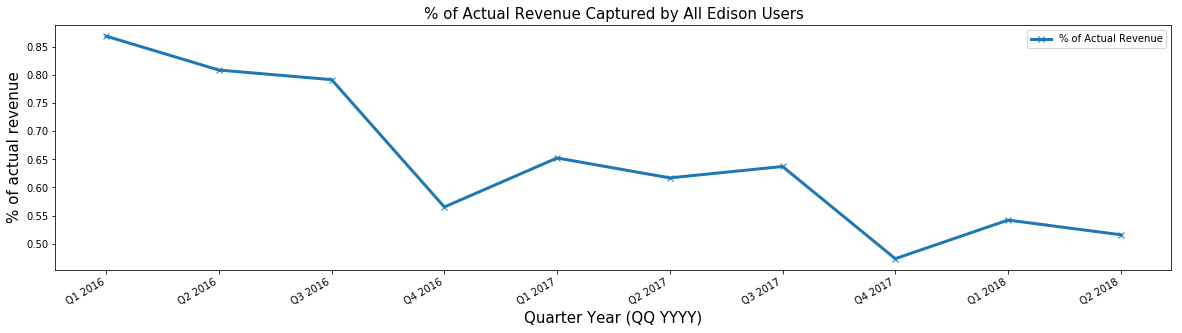

In [33]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(s1.index, s1.values, marker='x', linestyle='-', linewidth = 3, label = "% of Actual Revenue")
fig.autofmt_xdate()
ax.legend();
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("% of actual revenue", fontsize = 15);
plt.title("% of Actual Revenue Captured by All Edison Users", fontsize = 15);
plt.show()

### Looking at growth by Year but same Quarter.

               sum(order_total)
order_quarter                  
Q1 2017                0.153692
Q1 2018                0.286733
               sum(order_total)
order_quarter                  
Q2 2017                0.194103
Q2 2018                0.223014
               sum(order_total)
order_quarter                  
Q3 2017                0.265976
               sum(order_total)
order_quarter                  
Q4 2017                0.219547


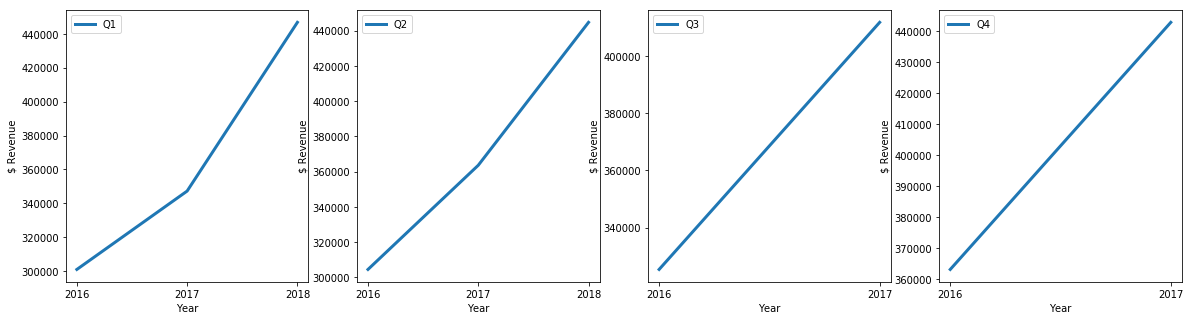

In [34]:
Q = ["Q1", "Q2", "Q3", "Q4"]
fig = plt.figure(figsize=(20, 5))
for i in range(len(Q)):
    x = [col for col in revenue_domestic.index if str(Q[i]) in col]
    xlab = [col[3:] for col in x]
    temp = 141 + i
    ax = fig.add_subplot(temp)
    if Q[i] == "Q3":
        ax.plot(xlab[:-1], revenue_domestic[revenue_domestic.index.isin(x)][:-1].values, label = Q[i], linewidth = 3)
        print(revenue_domestic[revenue_domestic.index.isin(x)][:-1].pct_change().dropna())
    else:
        ax.plot(xlab, revenue_domestic[revenue_domestic.index.isin(x)], label = Q[i], linewidth = 3)
        print(revenue_domestic[revenue_domestic.index.isin(x)].pct_change().dropna())
    plt.legend()
    plt.xlabel("Year");
    plt.ylabel("$ Revenue");

         Actual Revenue
Quarter                
Q1 2017        0.172411
Q1 2018        0.120011
         Actual Revenue
Quarter                
Q2 2017        0.182677
Q2 2018        0.060859
         Actual Revenue
Quarter                
Q3 2017        0.136005
         Actual Revenue
Quarter                
Q4 2017        0.048576


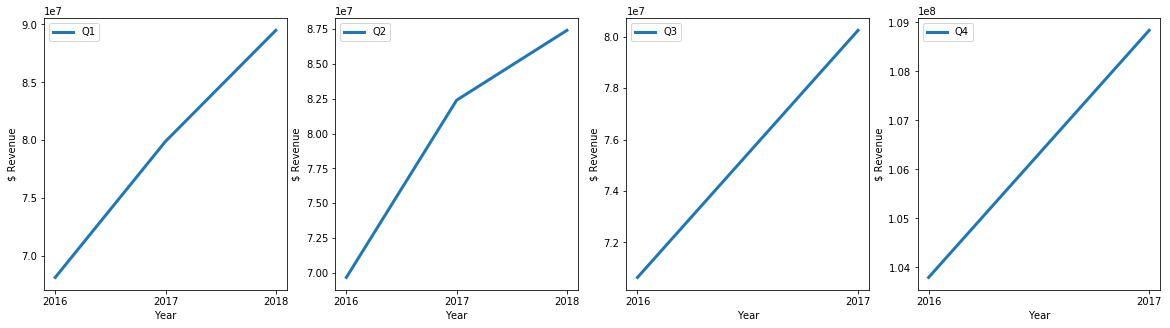

In [35]:
fig = plt.figure(figsize=(20, 5))
for i in range(len(Q)):
    x = [col for col in actual_revenue.index if str(Q[i]) in col]
    xlab = [col[3:] for col in x]
    temp = 141 + i
    ax = fig.add_subplot(temp)
    ax.plot(xlab, actual_revenue[actual_revenue.index.isin(x)], label = Q[i], linewidth = 3)
    print(actual_revenue[actual_revenue.index.isin(x)].pct_change().dropna())
    plt.legend()
    plt.xlabel("Year");
    plt.ylabel("$ Revenue");

### Calculating monthly revenue

In [36]:
monthly_revenue = orders_domestic.groupBy(func.year("order_time").alias("year"), month("order_time").alias("month")).agg(func.sum("order_total").alias("total sales")).toPandas()
monthly_revenue = monthly_revenue.groupby(["year", "month"])["total sales"].sum().to_frame()

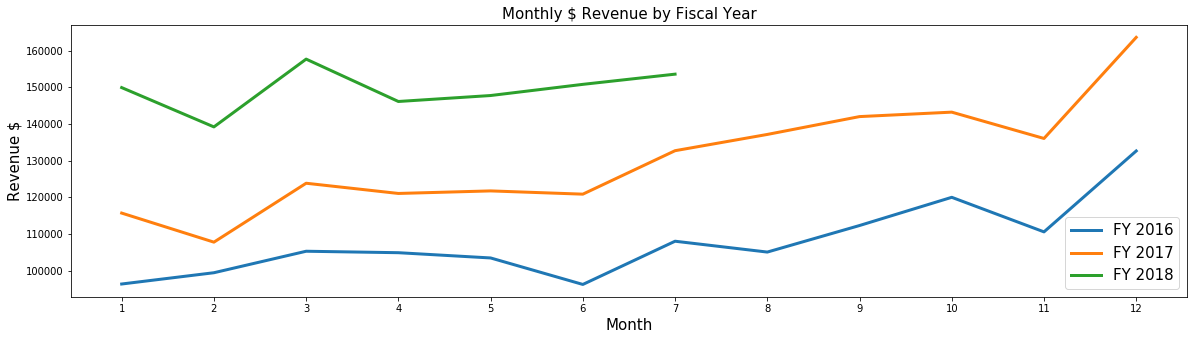

In [37]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
for yr in range(2016, 2019):
    ax.plot(monthly_revenue.unstack(level=0)["total sales"][yr], linewidth = 3, label ="FY "+str(yr));
plt.xlabel("Month", fontsize = 15);
plt.ylabel("Revenue $", fontsize = 15);
plt.title("Monthly $ Revenue by Fiscal Year", fontsize = 15)
ax.set_xticks([i for i in range(1, 13)]);
ax.legend(loc="best", fontsize = 15);

### Monthly $ Revenue Time Series

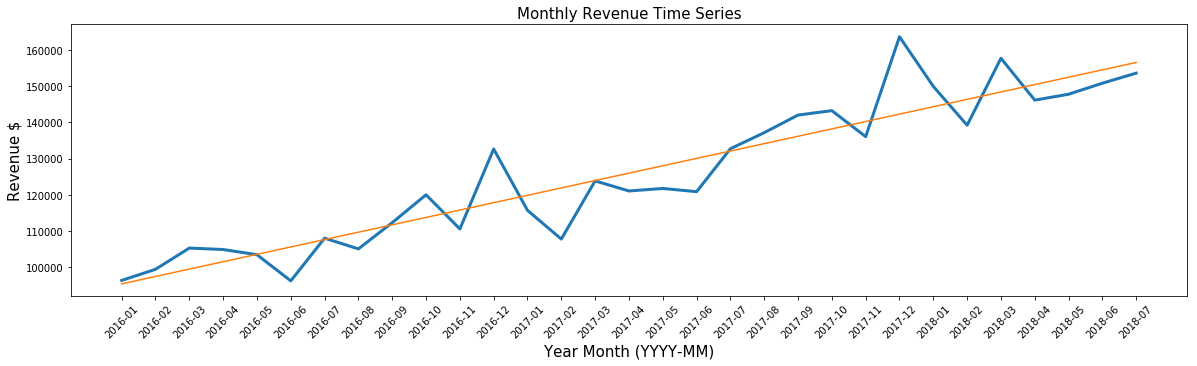

In [38]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot(monthly_revenue["total sales"].values, linewidth = 3)
ax.plot(trend(monthly_revenue["total sales"].values))
ax.set_xticks(range(len(monthly_revenue)));
plt.ylabel("Revenue $", fontsize = 15);
plt.xlabel("Year Month (YYYY-MM)", fontsize = 15);
plt.title("Monthly Revenue Time Series", fontsize = 15);
ax.set_xticklabels(["%s-%02d" % item for item in monthly_revenue.index.tolist()], rotation=45);

### Quarterly Revenue Time Series Plot

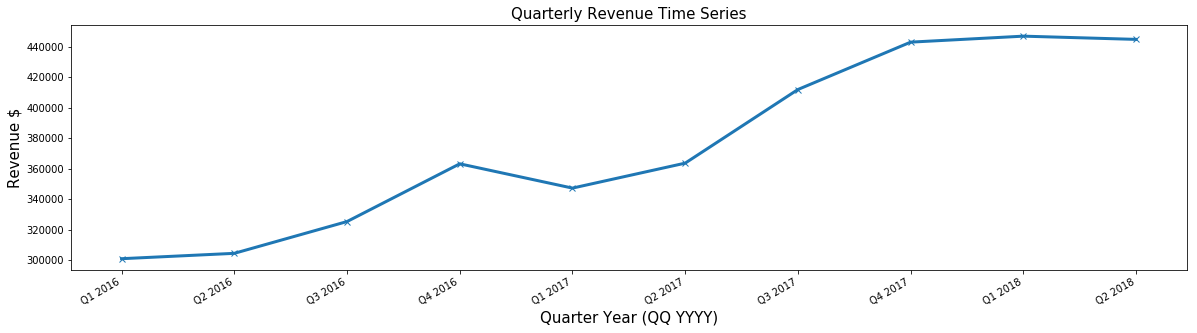

In [39]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(revenue_domestic.index[:-1], revenue_domestic["sum(order_total)"][:-1], marker='x', linestyle='-', linewidth = 3);
fig.autofmt_xdate();
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("Revenue $", fontsize = 15);
plt.title("Quarterly Revenue Time Series", fontsize = 15);
plt.show();

In [40]:
#international data

data_international_2yrs = df.filter(df.user_create_time < to_timestamp(lit("2016-01-01 00:00:00"))).filter(
    df.expiry_time.isNull()).filter(df.order_time >= to_timestamp(lit("2016-01-01 00:00:00")))

In [41]:
orders_international = data_international_2yrs.groupBy("order_number").agg(func.first("order_total_amount").alias("order_total"), func.first("order_quarter").alias("order_quarter"),
                                                                          func.first("from_domain").alias("from_domain"))

In [42]:
orders_international.groupby("from_domain").agg(count("order_number").alias("# orders")).show()

+--------------------+--------+
|         from_domain|# orders|
+--------------------+--------+
|  orders@dominos.com|  167663|
|orders@dominos.co...|      16|
|                null|       7|
|orders@dominospr.com|      11|
|   orders@dominos.ky|       1|
|no-reply@vip.domi...|      71|
|webuser@dominos.c...|       1|
|   orders@dominos.ca|      20|
|no-reply@vip.domi...|      19|
|   orders@dominos.gu|       1|
+--------------------+--------+



it can be clearly seen that we don't have awful lot of international data and hence expect it to follow the same trend as domestic revenue.

In [43]:
revenue_international = orders_international.groupby("order_quarter").agg(func.sum("order_total")).toPandas()

In [44]:
revenue_international.set_index("order_quarter", inplace = True)
revenue_international = revenue_international.reindex(quarters_)
revenue_international

,sum(order_total)
order_quarter,
Q1 2016,301019.730715
Q2 2016,304495.679976
Q3 2016,325328.068643
Q4 2016,363192.871925
Q1 2017,347280.337674
Q2 2017,363689.830729
Q3 2017,412227.508841
Q4 2017,443088.882798
Q1 2018,447047.098601


### International Revenue Quarterly Time Series 

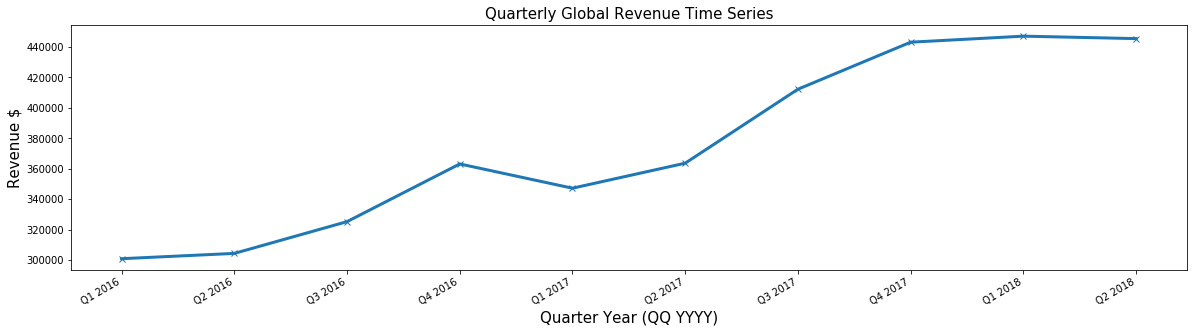

In [45]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(revenue_international.index[:-1], revenue_international["sum(order_total)"][:-1], marker='x', linestyle='-', linewidth = 3)
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("Revenue $", fontsize = 15);
plt.title("Quarterly Global Revenue Time Series", fontsize = 15);
fig.autofmt_xdate()
plt.show()

In the code below, I try to bootstrap samples each quarter and estimate average order price and revenue with 2 sigma confidence intervals. This is done only for domestic stores.

In [46]:
mean_quarter = []
sd_quarter = []
sum_ = []
sd_ = []

for quarter in quarters_:
    quarter_data = orders_domestic.filter(orders_domestic.order_quarter == quarter).toPandas()
    temp1 = []
    temp2 = []
    for cycle in range(0,200):
        df_temp = quarter_data.sample(frac = 1.0, replace = True)
        temp1.append(np.mean(df_temp["order_total"]))
        temp2.append(sum(df_temp["order_total"]))
    
    mean_quarter.append(np.mean(temp1))
    sd_quarter.append(np.std(temp1))
    sum_.append(np.mean(temp2))
    sd_.append(np.std(temp2))

# Bootstrapping is used to determine the quarterly revenue and average order size.

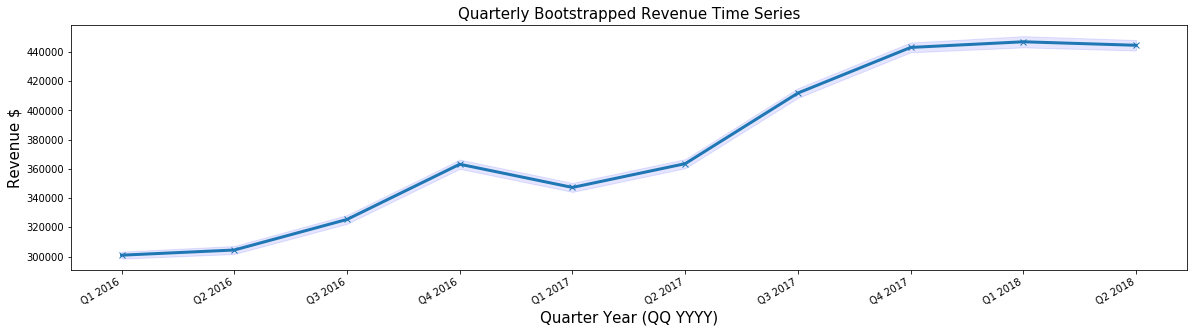

In [47]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
plt.plot(quarters_[:-1], sum_[:-1], linewidth = 3, marker = "x")
sigma_2neg = np.array(sum_) - 2*np.array(sd_)
sigma_2pos = np.array(sum_) + 2*np.array(sd_)
plt.fill_between(quarters_[:-1], sigma_2neg[:-1], sigma_2pos[:-1], color = "b", alpha = 0.1)
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("Revenue $", fontsize = 15);
plt.title("Quarterly Bootstrapped Revenue Time Series", fontsize = 15);
fig.autofmt_xdate()
plt.show()

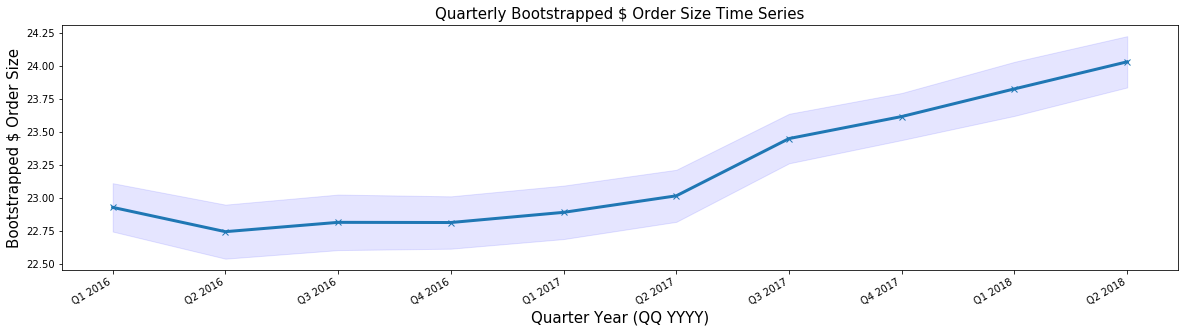

In [48]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
plt.plot(quarters_[:-1], mean_quarter[:-1], linewidth = 3, marker = "x")
sigma_2neg = np.array(mean_quarter) - 2*np.array(sd_quarter)
sigma_2pos = np.array(mean_quarter) + 2*np.array(sd_quarter)
plt.fill_between(quarters_[:-1], sigma_2neg[:-1], sigma_2pos[:-1], color = "b", alpha = 0.1)
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("Bootstrapped $ Order Size", fontsize = 15);
plt.title("Quarterly Bootstrapped $ Order Size Time Series", fontsize = 15);
fig.autofmt_xdate()
plt.show()

### Plotting the percentage change in domestic revenue

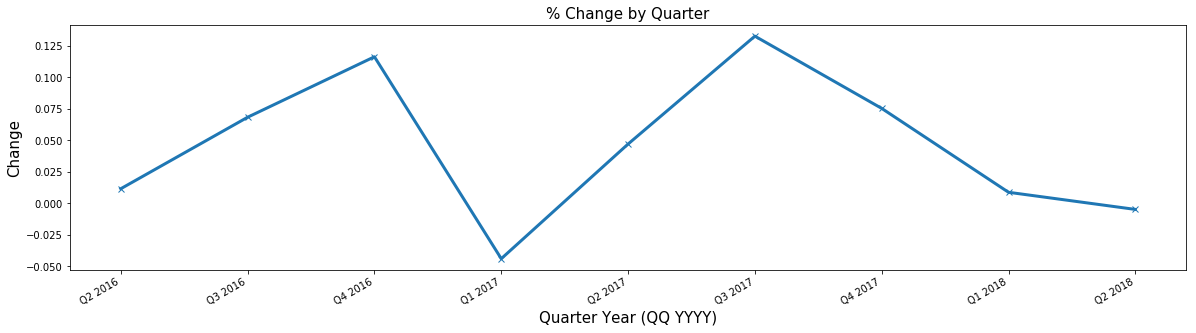

In [49]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(revenue_domestic.pct_change().index[:-1], revenue_domestic.pct_change()["sum(order_total)"][:-1], marker='x', linestyle='-', linewidth = 3)
fig.autofmt_xdate()
plt.xlabel("Quarter Year (QQ YYYY)", fontsize = 15);
plt.ylabel("Change", fontsize = 15);
plt.title("% Change by Quarter", fontsize = 15);
plt.show()

In [50]:
start_date = "2016-01-01 00:00:00"
final_end_date = "2018-07-01 00:00:00"
flag = True
while flag:
    start_date_dt_format = ts.Date(start_date).date
    end_date_dt_format = start_date_dt_format + relativedelta(months=+6)
    end_date_spark_format = end_date_dt_format.strftime("%Y-%m-%d %H:%M:%S")
    if end_date_spark_format == final_end_date:
        flag = False
    order_this_period = orders_.filter(orders_.user_create_time < to_timestamp(lit(start_date))).filter(
        (orders_.order_time>=to_timestamp(lit(start_date))) & (orders_.order_time < to_timestamp(lit(end_date_spark_format)))).filter((
    orders_.expiry_time.isNull()) | (orders_.expiry_time >= to_timestamp(lit(end_date_spark_format))))
    revenue = order_this_period.groupby("order_quarter").agg(func.sum("order_total")).toPandas()
    print(revenue)
    start_date = (start_date_dt_format +relativedelta(months =+3)).strftime("%Y-%m-%d %H:%M:%S")

  order_quarter  sum(order_total)
0       Q1 2016     558545.459614
1       Q2 2016     550925.749685
  order_quarter  sum(order_total)
0       Q3 2016     548998.669510
1       Q2 2016     527896.159719
  order_quarter  sum(order_total)
0       Q3 2016     498921.599569
1       Q4 2016     559995.209893
  order_quarter  sum(order_total)
0       Q4 2016     519438.609942
1       Q1 2017     503475.069597
  order_quarter  sum(order_total)
0       Q1 2017     467642.619610
1       Q2 2017     487697.269691
  order_quarter  sum(order_total)
0       Q3 2017     491549.119845
1       Q2 2017     436712.759703
  order_quarter  sum(order_total)
0       Q3 2017     459701.559849
1       Q4 2017     496729.269707
  order_quarter  sum(order_total)
0       Q1 2018     468660.269611
1       Q4 2017     463752.919748
  order_quarter  sum(order_total)
0       Q1 2018     435708.739621
1       Q2 2018     434276.649894


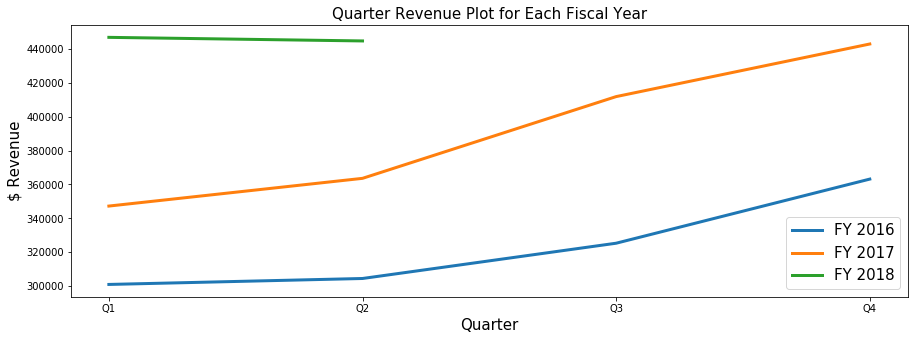

In [51]:
rev = revenue_domestic[:-1].copy()
fig = plt.figure(figsize=(15, 5));
ax = fig.add_subplot(111);
for year in range(2016, 2019):
    x = [col for col in rev.index if str(year) in col]
    xlab = [col[0:2] for col in x]
    ax.plot(xlab, rev[rev.index.isin(x)], label = "FY "+str(year), linewidth = 3)
plt.legend(fontsize = 15);
plt.xlabel("Quarter", fontsize = 15);
plt.ylabel("$ Revenue", fontsize = 15);
plt.title("Quarter Revenue Plot for Each Fiscal Year", fontsize = 15);

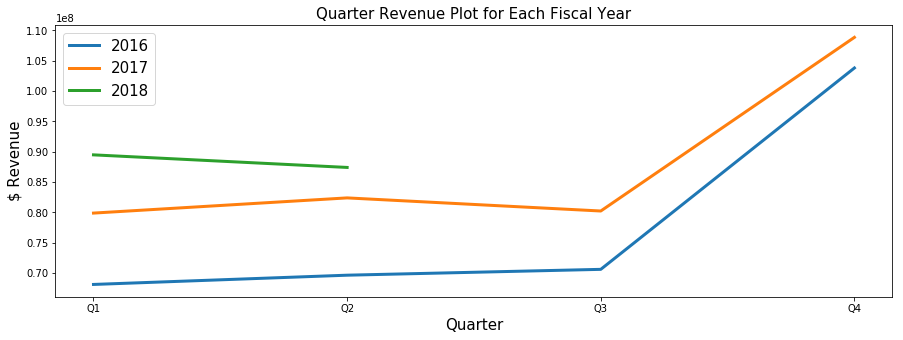

In [52]:
fig = plt.figure(figsize=(15, 5));
ax = fig.add_subplot(111);
for year in range(2016, 2019):
    x = [col for col in actual_revenue.index if str(year) in col]
    xlab = [col[0:2] for col in x]
    plt.plot(xlab, actual_revenue[actual_revenue.index.isin(x)], label = str(year), linewidth = 3)
plt.legend(fontsize = 15);
plt.xlabel("Quarter", fontsize = 15);
plt.ylabel("$ Revenue", fontsize = 15);
plt.title("Quarter Revenue Plot for Each Fiscal Year", fontsize = 15);

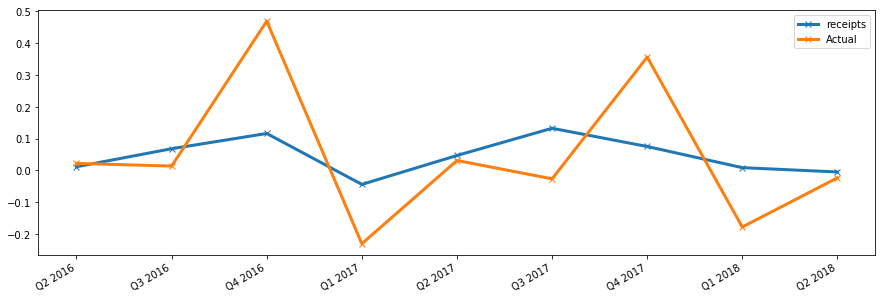

In [53]:
fig = plt.figure(figsize=(15, 5));
ax = fig.add_subplot(111);
ax.plot_date(revenue_domestic.pct_change().index[:-1], revenue_domestic.pct_change()["sum(order_total)"][:-1], marker='x', linestyle='-', linewidth = 3, label = "receipts")
ax.plot_date(actual_revenue.pct_change().index, actual_revenue.pct_change()["Actual Revenue"], marker='x', linestyle='-', linewidth = 3, label = "Actual")
fig.autofmt_xdate()
ax.legend();
plt.show()

In [54]:
s = revenue_domestic["sum(order_total)"][:-1].mul(100).div(actual_revenue["Actual Revenue"])

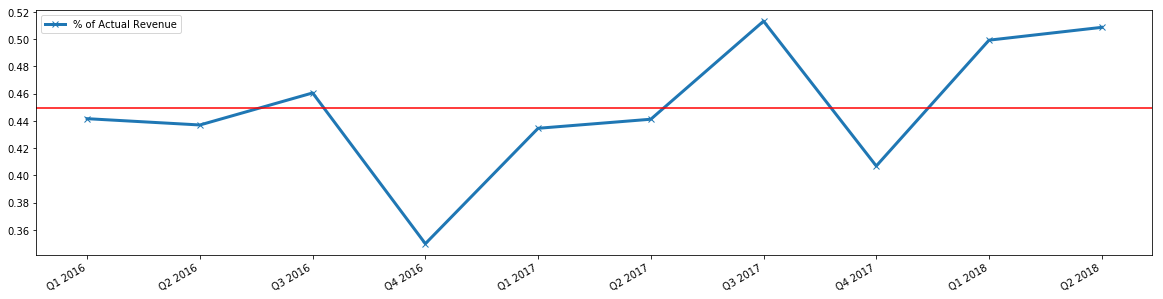

In [55]:
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
ax.plot_date(s.index, s.values, marker='x', linestyle='-', linewidth = 3, label = "% of Actual Revenue")
fig.autofmt_xdate()
ax.legend();
plt.axhline(y=s.mean(), color='r', linestyle='-')
plt.show()

### On an average, sales from the receipt data is 0.45% of the actual revenue. 

In [56]:
s.mean()

0.4493031862772

### There's a correlation of 0.68 between the Actual Reported quarterly revenue and sales estimated from receipts.

So below it can be clearly seen that there's a correlation of 0.68 between the Actual Revenue and Revenue from receipt data.

In [57]:
np.corrcoef(revenue_domestic[:-1]["sum(order_total)"].values, actual_revenue["Actual Revenue"].values)

array([[1.        , 0.68648075],
       [0.68648075, 1.        ]])

### And a correlation of 0.655 between the percentage changes of Actual Revenue and Revenue from receipt data.

In [58]:
a = revenue_domestic[:-1]["sum(order_total)"].pct_change().values
b = actual_revenue["Actual Revenue"].pct_change().values
np.corrcoef(a[1:],b[1:])

array([[1.        , 0.65587575],
       [0.65587575, 1.        ]])

### Linear regression is performed with quarterly percentage changes from receipt sales as independent variable and # quarterly percentage changes from actual revenue as dependent variable.

#### % Change in Actual Reported Revenue ~ % Change in Sales estimated from Receipts + epsilon.

#### It wouldn't be fair if we don't look at the R squared value. To be honest, R squared of only 0.45 was acheived. This could be due to some higher order interaction or we are not able to capture all the sales (as seen earlier 0.45%).

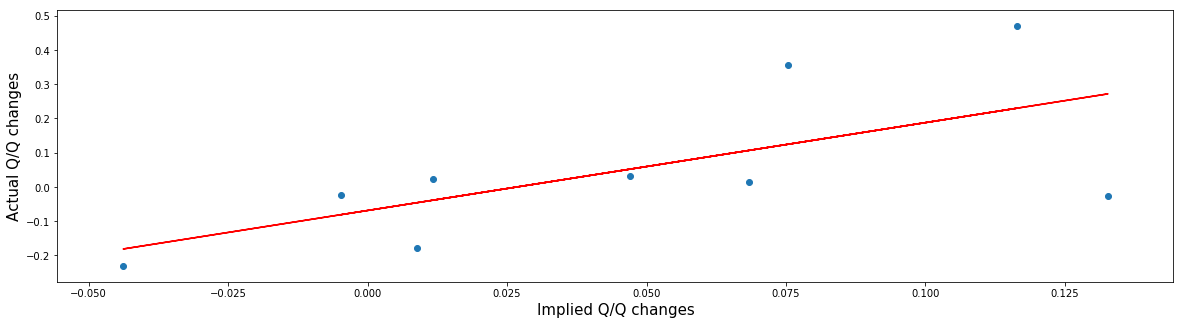

In [117]:
x=a[1:]
y=b[1:]
model_linear = LinearRegression()
fig = plt.figure(figsize=(20, 5));
ax = fig.add_subplot(111);
model_linear.fit(np.array(x).reshape(-1,1),y)
# calculate trend
trend = model_linear.predict(np.array(x).reshape(-1,1))
plt.scatter(x, y)
plt.plot(x, trend, color="red");
plt.xlabel("Implied Q/Q changes", fontsize = 15);
plt.ylabel("Actual Q/Q changes", fontsize = 15);

# Predicting Q3 2018.

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [106]:
model = ExponentialSmoothing(monthly_revenue["total sales"].values, seasonal="add", trend="add", seasonal_periods=12).fit()

In [107]:
model.forecast(2)

array([157909.59510176, 162126.83733009])

In [61]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [62]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [65]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return np.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

Test MSE: 71043088.323
Test RMSE: 8428.706


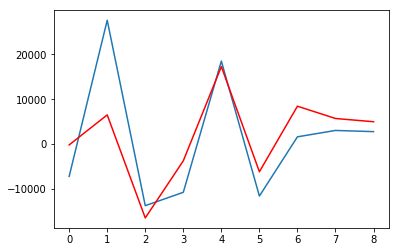

In [91]:
# split dataset
X = difference(monthly_revenue["total sales"].values)
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=7, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**(0.5))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

This is how well we expect the model to perform on average when making forecasts on new data.

https://stats.stackexchange.com/questions/169260/cross-validation-what-is-the-standard-deviation-if-the-same-value-is-obtained-f

In [70]:
X = difference(monthly_revenue["total sales"].values)
# fit model
model = AR(X)
model_fit = model.fit(maxlag=7, disp=False)
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
np.save('ar_data.npy', X)
# save the last ob
np.save('ar_obs.npy', [monthly_revenue["total sales"].values[-1]])

In [71]:
from statsmodels.tsa.ar_model import ARResults
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
print(last_ob)

[ 7.28935423e+03 -7.13088760e-01 -6.33544203e-01 -3.17726572e-02
 -2.31519165e-01 -1.05014527e-01 -4.95369852e-01 -2.04143248e-01]
[153586.70991708]


In [81]:
model = ARResults.load('ar_model.pkl')
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data)+2)
# transform prediction
yhat1 = predictions[0] + last_ob
yhat2 = predictions[1] + yhat1

print("August 2018: %.3f" %yhat1[0])
print("September 2018: %.3f" %yhat2[0])

August 2018: 165755.679
September 2018: 156371.587


In [95]:
Estimated_Q3 = (last_ob + yhat1 +yhat2)/0.0045

In [108]:
Estimated_Q3_sales = (last_ob + yhat1 +yhat2)

In [97]:
Estimated_Q3_upper = (last_ob + yhat1 +2 *error**0.5 +yhat2)/0.0045

In [96]:
Estimated_Q3

array([1.05714217e+08])

In [101]:
Estimated_Q3_upper = (last_ob + yhat1 + 2 *error**0.5 +yhat2)/0.0045

In [102]:
Estimated_Q3_lower = (last_ob + yhat1 - 2 *error**0.5 +yhat2)/0.0045

In [114]:
percent_change = (Estimated_Q3_sales/revenue_domestic["sum(order_total)"][-2] -1)

In [115]:
percent_change

array([0.06977293])

In [119]:
forecast_linear_trend = model_linear.predict(percent_change.reshape(-1,1))

In [120]:
forecast_linear_trend

array([0.11006548])

In [126]:
actual_revenue["Actual Revenue"][-1] * (1+forecast_linear_trend)

array([97039703.91077696])

# Deriving value from prediction.

Based on our prediction and comparing it with estimates from analysts (Bloomberg, marketwatch, etc.) we could judge if Domino's pizza will hit or miss that estimate. For example, if the estimates from analyst says revenue would be around $1.5e8, then from our estimate it would be miss. From trading point of view, go long on a put or short the stocks as it is observed that stock prices drops based on miss, meet or beat. Opposite position can be taken in case if our estimate is greater than what is estimated by analysts. This all holds true and profitable assuming that our prediction is to the point. 

Data was provided only for July 2018. Data for August and September 2018 will help us get a better estimate of the actual revenue. Also, we were able to capture only 0.45% of the actual revenue. Moreover, we don't have information on how many orders were cancelled and some of the order total value is zero which could be wrong. If I had more time, I would have gone back to see how domino's has performed in the years before 2016. Has it followed the same trend? This would help us gauge the performance better. We also need to account for other biases like who uses Edison, location of majority of the users, etc.